In [26]:
import pandas as pd
!pip install text_preprocessing
import text_preprocessing as tp
from gensim.models import Word2Vec,KeyedVectors
import gensim.downloader
import re
import numpy as np
import time
from tensorflow import math
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Subtract, Lambda,concatenate,BatchNormalization, Dropout,Flatten,Dot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [27]:
def preprocess_data(description,data,output,mode="train"):
    data = data.merge(description,how="left",on='product_uid')
    df = pd.DataFrame()
    descriptions=[]
    titles=[]
    searches=[]
    for index, row in data.iterrows():
        description = row['product_description']
        search = row['search_term']
        title = row['product_title']
        description = process_text_line(description)
        search = process_text_line(search)
        title = process_text_line(title)
        descriptions.append(description)
        titles.append(title)
        searches.append(search)
    df['id'] = data['id']
    df['product_uid'] = data['product_uid']
    df['search'] = searches
    df['title'] = titles
    df['description'] = descriptions
    if mode == "train":
        df['relevane'] = data['relevance']
    df.to_csv(output,index=False)

def process_text_line(line):
    line = re.sub(r'[^\w\s]', ' ', line)
    words = line.split()
    first_preprocess = [tp.keep_alpha_numeric,tp.remove_punctuation,tp.to_lower,tp.lemmatize_word,tp.remove_stopword]
    clean_words = []
    for word in words:
        word = tp.preprocess_text(word, first_preprocess)
        if len(word) <= 0:
            continue
        number = re.findall(r'\d+', word)
        if len(number) <= 0:
            clean_words.append(word)
        else:
            if len(number[0])==len(word):
                clean_words.append(word)
            else:
                numbers = re.split('(\d+)', word)
                for number in numbers:
                    if len(number)>0:
                        clean_words.append(number)
    line_string = ' '.join(clean_words)
    return line_string

def create_word_dic(data_path):
    df = pd.read_csv(data_path)
    word_frequency = {}
    for index,row in df.iterrows():
        line = [row['attributes'],row['description'],row['title'],row['search']]
        line = ' '.join(line)
        line = line.split(" ")
        line_set = set(line)
        line_set.discard(' ')
        line_set.discard('')
        line_set = [x.lower() for x in line_set]
        for word in line_set:
            if word in word_frequency:
                word_frequency[word]+=1
            else:
                word_frequency[word]=1
    return word_frequency

def create_dataset(data,desc_size=256,title_size=36,search_size=15):
    data['description'] = data.description.str.split()[:desc_size]
    data['title'] = data.title.str.split()[:title_size]
    data['search'] = data.search.str.split()[:search_size]
    return data


In [28]:
def create_word2vec(data,window_size=4,epochs=50,min_count=2,size=32):
    desc_array = data['description'].str.split().values
    title_array = data['title'].str.split().values
    search_array = data['search'].str.split().values
    all_text = np.concatenate((desc_array,title_array,search_array))
    model = Word2Vec(sentences=all_text, window=window_size,
                        size=size,sorted_vocab=1,
                        compute_loss=1, iter = epochs,
                        min_count=min_count)
    model.wv.save("/content/drive/MyDrive/assignment3/word2vec"+str(size)+".bin")
    model.wv.save_word2vec_format("/content/drive/MyDrive/assignment3/word2vec"+str(size)+".txt",binary=False)
    return model

def create_pretrain_word2vec():
    vectores = gensim.downloader.load('glove-wiki-gigaword-100')
    return vectores

In [29]:
def plot_model_indicator(history, train_indicator, val_indicator, title, x_label, y_label, legend):
  plt.plot(history[train_indicator])
  plt.plot(history[val_indicator])
  plt.title(title)
  plt.ylabel(x_label)
  plt.xlabel(y_label)
  plt.legend(legend, loc='upper left')
  plt.show()

def calculate_score(y_pred,y_true,model_name="Siamise model",data_type="Train"):
    val_mse = mean_squared_error(y_true, y_pred)
    val_rmse = mean_squared_error(y_true, y_pred, squared=False)
    val_mae = mean_absolute_error(y_true, y_pred)
    print(model_name + " " + data_type+" score MSE - " + str(val_mse))
    print(model_name + " " + data_type+" score RMSE - " + str(val_rmse))
    print(model_name + " " + data_type+" score MAE - " + str(val_mae))

In [30]:
def create_data_to_model(data, word2vec, search_size=16,title_size=32,desc_size=128,mode='sequence',expand=False):
    desc_array = data['description'].str.lower().str.split()
    title_array = data['title'].str.lower().str.split()
    search_array = data['search'].str.lower().str.split()
    desc_input = create_column_input(desc_array,word2vec,desc_size,mode,expand)
    title_input = create_column_input(title_array, word2vec, title_size,mode,expand)
    search_input = create_column_input(search_array, word2vec, search_size,mode,expand)
    return np.array(desc_input),np.array(title_input),np.array(search_input)

def create_column_input(data,word2vec,size,mode="sequence",expand=False):
    new_data = []
    for sentence in data:
        new_sentence=[]
        if mode == 'set':
            sentence = set(sentence)
        for word in sentence:
            if word in word2vec.vocab:
                word_vec = word2vec.vocab[word].index
                new_sentence.append(word_vec)
        if len(new_sentence) > size:
            new_sentence = new_sentence[:size]
        elif len(new_sentence) < size:
            if len(new_sentence) <1:
                new_sentence.append(0)
            elif expand :
                new_sentence = expand_sentence(word2vec,sentence,new_sentence,size)
            while len(new_sentence) < size:
                new_sentence.append(0)
        new_data.append(new_sentence)
    return new_data

def expand_sentence(word2vec,words,new_words,size,threshold=0.70):
    n = size // len(new_words)
    for word in words:
        if word in word2vec.vocab:
            similar_words = word2vec.most_similar(positive=[word],topn=n)
            for sw in similar_words:
                sw1 = word2vec.vocab[sw[0]].index
                if not sw1 in new_words and sw[1] > threshold:
                    new_words.append(sw1)
                elif sw[1]< threshold:
                    break
        if len(new_words)>=size:
            break
    return new_words[:size]

In [31]:
def build_siamese_model(word2vec,search_size=16,title_size=32,desc_size=128,emb_size=32):

    # Input layers
    search_input = Input((search_size,), name="search_input")
    title_input = Input((title_size,), name="title_input")
    description_input = Input((desc_size,), name="desc_input")

    # Embedding layers
    search_emb = Embedding(len(word2vec),emb_size , weights=[word2vec], input_length=search_size, name="search_emb",trainable=False,mask_zero=True)(search_input)
    title_emb = Embedding(len(word2vec), emb_size, weights=[word2vec], input_length=title_size, name='title_emb',trainable=False,mask_zero=True)(title_input)
    description_emb = Embedding(len(word2vec), emb_size, weights=[word2vec], input_length=desc_size,name='desc_emb',trainable=False,mask_zero=True)(description_input)

    # LSTM
    search_lstm = LSTM(128, activation='tanh', name='search_lstm',kernel_regularizer=l2())(search_emb)
    title_lstm = LSTM(128, activation='tanh', name='title_lstm',kernel_regularizer=l2())(title_emb)
    desc_lstm = LSTM(128, activation='tanh', name='desc_lstm',kernel_regularizer=l2())(description_emb)

    # normalize
    search_lstm = BatchNormalization()(search_lstm)
    title_lstm = BatchNormalization()(title_lstm)
    desc_lstm = BatchNormalization()(desc_lstm)

    # dropout
    search_lstm = Dropout(0.3)(search_lstm)
    title_lstm = Dropout(0.3)(title_lstm)
    desc_lstm = Dropout(0.3)(desc_lstm)

    # output
    search_output = Dense(64, activation='relu', name='search_Output',use_bias=True)(search_lstm)
    title_output = Dense(64, activation='relu', name='title_Output',use_bias=True)(title_lstm)
    description_output = Dense(64, activation='relu', name='desc_Output',use_bias=True)(desc_lstm )

    # suntract between search to each
    description_similarity = Subtract(name='subtract1')([search_output, description_output])
    title_similarity = Subtract(name='subtract2')([search_output, title_output])

    # calculate_similarty between search to description, title, attributes one vs one
    description_similarity = Lambda(lambda x: math.abs(x))(description_similarity)
    title_similarity = Lambda(lambda x: math.abs(x))(title_similarity)

    # calculate relevance
    x = concatenate([description_similarity,title_similarity],name="features_exract")
    relevance = Dense(1, activation='relu',name='Model_Output',use_bias=True)(x)
    siamese_net = Model(inputs=[search_input, description_input,title_input], outputs=relevance)
    return siamese_net


def setcallbacks(patience=5, description="run"):
    er = EarlyStopping(patience=patience)
    rlp = ReduceLROnPlateau(patience=2, factor=0.1, min_lr=1e-5)
    mcp = ModelCheckpoint('best_model_weights_{}.h5'.format(description), save_best_only=True, monitor='val_loss')
    callbacks = [er, rlp, mcp]
    return callbacks

In [32]:
def create_feature_extraction_model(siamese_model):
    model = Model(siamese_model.input,siamese_model.get_layer('features_exract').output)
    for layer in model.layers:
        layer.trainable = False
    return model

In [33]:
# params
batch_size=128
epochs = 20
search_size = 9
title_size = 16
desc_size =96
emb_size = 48
padding=False
expand_words =False
set_dataset = False
expand_data=True
create_word2wec=False
normalize=True
load_word2vec=False

In [34]:
train_path= "/content/drive/MyDrive/assignment3/train_data.csv"
test_path= "/content/drive/MyDrive/assignment3/test_data.csv"
solution_path = "/content/drive/MyDrive/assignment3/solution.csv"
train_data = pd.read_csv(train_path).astype(str)
test_data = pd.read_csv(test_path).astype(str)
test_data = test_data.loc[test_data['Usage']!='Ignored']
sol_df = pd.read_csv(solution_path)
labels = sol_df.loc[sol_df['Usage'] != 'Ignored']
labels = labels['relevance']

In [35]:
if create_word2wec:
    word2vec = create_word2vec(train_data,size = emb_size)
    if normalize:
        word2vec.init_sims(replace=True)
    word2vec = word2vec.wv
elif not load_word2vec:
    word2vec_path = r"/content/drive/MyDrive/assignment3/word2vec" + str(emb_size) + ".bin"
    word2vec = KeyedVectors.load(word2vec_path)
    if normalize:
        word2vec.init_sims(replace=True)

if load_word2vec:
    word2vec = create_pretrain_word2vec()

In [36]:
descriptions,titles,searches = create_data_to_model(train_data,word2vec,search_size=search_size,
                         title_size=title_size,desc_size=desc_size,expand=expand_words)
if set_dataset:
   desc_set, title_set, search_set = create_data_to_model(train_data, word2vec,search_size=search_size,
                                                                    title_size=title_size,desc_size=desc_size,mode='set',expand=expand_words)
y = train_data['relevance'].astype(float)
spliter = ShuffleSplit(n_splits=1,test_size=0.2)
for train_index, test_index in spliter.split(train_data):
    search_train = searches[train_index]
    search_val = searches[test_index]
    title_train = titles[train_index]
    title_val = titles[test_index]
    description_train = descriptions[train_index]
    description_val = descriptions[test_index]
    y_val = y[test_index]
    y_train = y[train_index]
    if set_dataset:
        search_train =np.concatenate((search_train, search_set[train_index]))
        search_val = np.concatenate((search_val, search_set[test_index]))
        title_train = np.concatenate((title_train, title_set[train_index]))
        title_val = np.concatenate((title_val, title_set[test_index]))
        description_train =np.concatenate((description_train, desc_set[train_index]))
        description_val =np.concatenate((description_val, desc_set[test_index]))
        y_val = y_val.append(y[test_index])
        y_train = y_train.append(y[train_index])
    if expand_data:
        mask_train = (y_train < 1.4) | (y_train > 2.8)
        search_train = np.concatenate((search_train, search_train[mask_train]))
        title_train = np.concatenate((title_train, title_train[mask_train]))
        description_train = np.concatenate((description_train, description_train[mask_train]))
        y_train = y_train.append(y_train[mask_train])
        mask_val = (y_val < 1.4) | (y_val > 2.8)
        search_val = np.concatenate((search_val, search_val[mask_val]))
        title_val = np.concatenate((title_val, title_val[mask_val]))
        description_val = np.concatenate((description_val, description_val[mask_val]))
        y_val = y_val.append(y_val[mask_val])

In [37]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

siamese_model = build_siamese_model(word2vec.vectors,desc_size=desc_size,title_size=title_size,search_size=search_size,emb_size=emb_size)
siamese_model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae', keras.metrics.RootMeanSquaredError()])
siamese_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
search_input (InputLayer)       [(None, 9)]          0                                            
__________________________________________________________________________________________________
desc_input (InputLayer)         [(None, 96)]         0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        [(None, 16)]         0                                            
__________________________________________________________________________________________________
search_emb (Embedding)          (None, 9, 48)        4218384     search_input[0][0]               
____________________________________________________________________________________________

Epoch 1/20
615/615 [==============================] - 280s 436ms/step - loss: 1.5662 - mse: 1.1462 - mae: 0.7953 - root_mean_squared_error: 1.0193 - val_loss: 0.8278 - val_mse: 0.7097 - val_mae: 0.7427 - val_root_mean_squared_error: 0.8424
Epoch 2/20
615/615 [==============================] - 263s 428ms/step - loss: 0.5362 - mse: 0.3565 - mae: 0.4710 - root_mean_squared_error: 0.5970 - val_loss: 0.5059 - val_mse: 0.3955 - val_mae: 0.4722 - val_root_mean_squared_error: 0.6289
Epoch 3/20
615/615 [==============================] - 266s 433ms/step - loss: 0.4874 - mse: 0.3409 - mae: 0.4555 - root_mean_squared_error: 0.5838 - val_loss: 0.4933 - val_mse: 0.3830 - val_mae: 0.4683 - val_root_mean_squared_error: 0.6189
Epoch 4/20
615/615 [==============================] - 265s 430ms/step - loss: 0.4757 - mse: 0.3344 - mae: 0.4503 - root_mean_squared_error: 0.5783 - val_loss: 0.4936 - val_mse: 0.3330 - val_mae: 0.4706 - val_root_mean_squared_error: 0.5771
Epoch 5/20
615/615 [====================

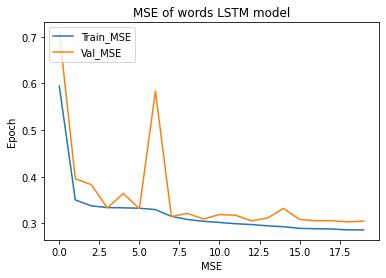

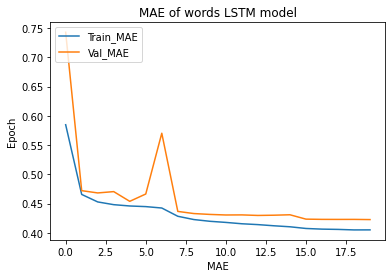

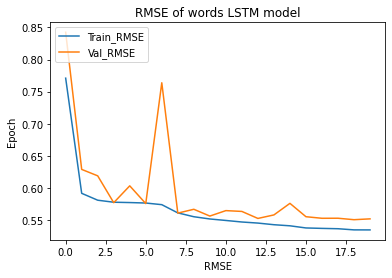

In [38]:
start = time.time()
history = siamese_model.fit(x=[search_train,description_train, title_train],y=y_train,
                            epochs=epochs, batch_size=batch_size,callbacks=setcallbacks(),
                            validation_data=([search_val,description_val,title_val],y_val))

runtime = time.time() - start
print("Runtime for "+str(siamese_model.history.params['epochs'])+" epochs is "+str(runtime)+" sec")

plot_model_indicator(history.history, 'mse', 'val_mse', 'MSE of words LSTM model', 'Epoch','MSE',['Train_MSE','Val_MSE'])
plot_model_indicator(history.history, 'mae', 'val_mae', 'MAE of words LSTM model', 'Epoch','MAE',['Train_MAE','Val_MAE'])
plot_model_indicator(history.history, 'root_mean_squared_error', 'val_root_mean_squared_error', 'RMSE of words LSTM model', 'Epoch','RMSE',['Train_RMSE','Val_RMSE'])

In [45]:
description_test, title_test, search_test = create_data_to_model(test_data,word2vec,
                                                                      search_size=search_size,title_size=title_size,desc_size=desc_size)

In [47]:
# load best validation score siamese model
siamese_model.load_weights('best_model_weights_run.h5')

# calculate siamese model scores
pred_train = siamese_model.predict([search_train,description_train,title_train])
calculate_score(pred_train,y_train,data_type="train")
pred_val = siamese_model.predict([search_val,description_val,title_val])
calculate_score(pred_val,y_val,data_type="validation")
predictions = siamese_model.predict([search_test,description_test,title_test])
calculate_score(predictions,labels,data_type="test")

Siamise model train score MSE - 0.27362934939421274
Siamise model train score RMSE - 0.5230959275259297
Siamise model train score MAE - 0.3927230594260611
Siamise model validation score MSE - 0.30455529901309214
Siamise model validation score RMSE - 0.551865290639928
Siamise model validation score MAE - 0.4228037309450646
Siamise model test score MSE - 0.2981880366711352
Siamise model test score RMSE - 0.5460659636629399
Siamise model test score MAE - 0.42210299478055935


In [48]:
# extract_features
model = create_feature_extraction_model(siamese_model)
x_train = model.predict([search_train, description_train, title_train])
x_val = model.predict([search_val, description_val, title_val])
x_test = model.predict([search_test, description_test, title_test])

In [49]:
# catboost regressor
catboost = CatBoostRegressor(iterations=3000,l2_leaf_reg=100,bootstrap_type='MVS',use_best_model=True,bagging_temperature=0.4,random_strength=0.3)
start = time.time()
catboost.fit(x_train,y_train,eval_set=(x_val,y_val,))
runtime = time.time() - start
print("Runtime for catboost is "+str(runtime)+" sec")

# calculate train, validation, test scores
train_pred = catboost.predict(x_train)
calculate_score(train_pred,y_train,"Catboost", "train")
val_pred = catboost.predict(x_val)
calculate_score(val_pred ,y_val,"Catboost", "validation")
test_pred = catboost.predict(x_test)
test_mse = mean_squared_error(labels,test_pred)
calculate_score(test_pred ,labels,"Catboost", "test")

0:	learn: 0.5976813	test: 0.6034849	best: 0.6034849 (0)	total: 161ms	remaining: 8m 1s
1:	learn: 0.5961093	test: 0.6021681	best: 0.6021681 (1)	total: 262ms	remaining: 6m 33s
2:	learn: 0.5945987	test: 0.6008837	best: 0.6008837 (2)	total: 351ms	remaining: 5m 50s
3:	learn: 0.5931559	test: 0.5996161	best: 0.5996161 (3)	total: 445ms	remaining: 5m 33s
4:	learn: 0.5917377	test: 0.5984882	best: 0.5984882 (4)	total: 535ms	remaining: 5m 20s
5:	learn: 0.5903744	test: 0.5973498	best: 0.5973498 (5)	total: 632ms	remaining: 5m 15s
6:	learn: 0.5890660	test: 0.5963123	best: 0.5963123 (6)	total: 728ms	remaining: 5m 11s
7:	learn: 0.5877667	test: 0.5952080	best: 0.5952080 (7)	total: 824ms	remaining: 5m 8s
8:	learn: 0.5865578	test: 0.5941587	best: 0.5941587 (8)	total: 917ms	remaining: 5m 4s
9:	learn: 0.5854154	test: 0.5931664	best: 0.5931664 (9)	total: 1.01s	remaining: 5m 2s
10:	learn: 0.5842447	test: 0.5921717	best: 0.5921717 (10)	total: 1.1s	remaining: 5m
11:	learn: 0.5830684	test: 0.5912649	best: 0.59126

In [50]:
# random forest regressor
rf = RandomForestRegressor(n_jobs=4, n_estimators=50, max_depth=8)
start = time.time()
rf.fit(x_train,y_train)
runtime = time.time() - start
print("Runtime for random forest is "+str(runtime)+" sec")

# calculate train, validation, test scores
train_pred = rf.predict(x_train)
calculate_score(train_pred,y_train,"Random forest", "train")
val_pred = rf.predict(x_val)
calculate_score(val_pred ,y_val,"Random forest", "validation")
test_pred = rf.predict(x_test)
test_mse = mean_squared_error(labels,test_pred)
calculate_score(test_pred ,labels,"Random forest", "test")

Runtime for random forest is 198.34645891189575 sec
Random forest train score MSE - 0.24840124212829118
Random forest train score RMSE - 0.4983986778958098
Random forest train score MAE - 0.4117338128604991
Random forest validation score MSE - 0.3040143945248096
Random forest validation score RMSE - 0.5513750035364403
Random forest validation score MAE - 0.45292419832828273
Random forest test score MSE - 0.2669557948798199
Random forest test score RMSE - 0.5166776508422054
Random forest test score MAE - 0.41450354403759954


In [44]:
# xgboost
xgboost = XGBRegressor(n_jobs=4)
start = time.time()
xgboost.fit(x_train,y_train)
runtime = time.time() - start
print("Runtime for xgboost  is "+str(runtime)+" sec")

# calculate train, validation, test scores
train_pred = xgboost.predict(x_train)
calculate_score(train_pred ,y_train, "Xgboost", "train")
val_pred = xgboost.predict(x_val)
calculate_score(val_pred,y_val, "Xgboost", "validation")
test_pred = xgboost.predict(x_test)
calculate_score(test_pred, labels, "Xgboost", "test")

[12:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Runtime for xgboost  is 45.68028020858765 sec
Xgboost train score MSE - 0.2580793360274498
Xgboost train score RMSE - 0.5080150942909569
Xgboost train score MAE - 0.413811619372074
Xgboost validation score MSE - 0.2945530134582597
Xgboost validation score RMSE - 0.5427273841057402
Xgboost validation score MAE - 0.4439555416155563
Xgboost test score MSE - 0.26317433996498746
Xgboost test score RMSE - 0.5130052046178357
Xgboost test score MAE - 0.411582668872936
